In [2]:
import pandas as pd
from patsy import dmatrices
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [3]:
data = pd.read_excel("C:\\Users\\SSP\\Desktop\\Dr_Baradaran\\spf.data.xlsx",header=2)
data.head()

,seg,Y,X1,X2,X3,X4,Unnamed: 6
0,59,49,4.344300,8076.666667,0.920747,4,1
1,58,44,9.025771,8076.666667,0.553969,5,2
2,57,35,9.401453,8076.666667,0.106367,1,3
3,56,1,0.685524,8076.666667,0.000000,0,4
4,55,5,1.494137,8076.666667,0.000000,0,5


In [12]:
#STEP1: fitting the Poisson regression model

mask = np.random.rand(len(data)) < 0.8
data_train = data[mask]
data_test = data[~mask]
print('Training data set length='+str(len(data_train)))
print('Testing data set length='+str(len(data_test)))

Training data set length=50
Testing data set length=9


In [13]:
expr = """Y ~ X1  + X2 + X3"""

In [14]:
y_train, X_train = dmatrices(expr, data_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, data_test, return_type='dataframe')

In [15]:
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
print(poisson_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      Y   No. Observations:                   50
Model:                            GLM   Df Residuals:                       46
Model Family:                 Poisson   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -212.51
Date:                Mon, 20 Jun 2022   Deviance:                       228.16
Time:                        17:52:38   Pearson chi2:                     240.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.9974
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.5729      0.845      4.230      0.0

In [16]:
print(poisson_training_results.mu)
print(len(poisson_training_results.mu))

[13.59882739 38.16475583 39.43329689  5.25296448  6.32573253  8.73843402
  5.26529295  6.22819147  8.34728481  6.48451309  7.86284525 25.75800975
  6.66092969  7.80099944 18.79098892 12.50388055 32.95911774 41.62761873
 10.01118639 11.0773348  27.04457488  7.76344532  9.07024844  9.99016404
  6.13921936  9.23015813  7.95970246  9.94353166  7.37284294  7.85130621
  6.26642981  8.0905017   8.86144331  7.91597336 13.69456609 21.71863121
 16.48743419 37.57895179  8.07327727  6.42598457 27.39475255  8.75245162
  9.44771476 31.4984061  10.66479779  6.58608807 13.77322359 14.37066871
 13.83193957 21.30936578]
50


In [17]:
#STEP 2: The determination of α

import statsmodels.formula.api as smf

In [18]:
data_train['Y_LAMBDA'] = poisson_training_results.mu

C:\Users\SSP\AppData\Local\Temp/ipykernel_6044/4190094296.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['Y_LAMBDA'] = poisson_training_results.mu


In [19]:
data_train['AUX_OLS_DEP'] = data_train.apply(lambda x: ((x['Y'] - x['Y_LAMBDA'])**2 - x['Y_LAMBDA']) / x['Y_LAMBDA'], axis=1)

C:\Users\SSP\AppData\Local\Temp/ipykernel_6044/2348541616.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['AUX_OLS_DEP'] = data_train.apply(lambda x: ((x['Y'] - x['Y_LAMBDA'])**2 - x['Y_LAMBDA']) / x['Y_LAMBDA'], axis=1)


In [20]:
ols_expr = """AUX_OLS_DEP ~ Y_LAMBDA - 1"""

In [21]:
aux_olsr_results = smf.ols(ols_expr, data_train).fit()

In [22]:
print(aux_olsr_results.params)

Y_LAMBDA    0.148111
dtype: float64


In [23]:
aux_olsr_results.tvalues

Y_LAMBDA    1.336886
dtype: float64

In [28]:
print("Critical t-value at a 99% confidence level (right-tailed), and degrees of freedom=49 is 2.404892")
print("which is not comfortably less than the t-statistic of alpha (1.336886)")
print("So α=0.148111 is NOT statistically significant")
print("Therefore, the Negative Binomial regression model cannot do a better job of fitting the training data set than a Poisson regression model.")

Critical t-value at a 99% confidence level (right-tailed), and degrees of freedom=49 is 2.404892
which is not comfortably less than the t-statistic of alpha (1.336886)
So α=0.148111 is NOT statistically significant
Therefore, the Negative Binomial regression model cannot do a better job of fitting the training data set than a Poisson regression model.


In [29]:
#STEP 3: Train the NB2 on the data using the alpha found in the previous step

nb2_training_results = sm.GLM(y_train, X_train,family=sm.families.NegativeBinomial(alpha=aux_olsr_results.params[0])).fit()

In [30]:
print(nb2_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      Y   No. Observations:                   50
Model:                            GLM   Df Residuals:                       46
Model Family:        NegativeBinomial   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -170.98
Date:                Mon, 20 Jun 2022   Deviance:                       96.041
Time:                        18:53:04   Pearson chi2:                     92.8
No. Iterations:                     8   Pseudo R-squ. (CS):             0.8525
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.6774      1.612      2.281      0.0

In [32]:
#STEP 4:  Make some predictions

nb2_predictions = nb2_training_results.get_prediction(X_test)

In [33]:
predictions_summary_frame = nb2_predictions.summary_frame()
print(predictions_summary_frame)

         mean   mean_se  mean_ci_lower  mean_ci_upper
9    9.703975  1.195095       7.622893      12.353203
22  27.835802  3.603061      21.598539      35.874272
23  23.779153  2.858619      18.787496      30.097046
25  10.330029  1.327367       8.030186      13.288547
34   9.443604  0.980799       7.704300      11.575569
39   8.021810  1.068154       6.179162      10.413942
48  20.874845  2.182591      17.006894      25.622500
49   7.483490  0.817244       6.041540       9.269596
55  10.660801  2.490075       6.744848      16.850295


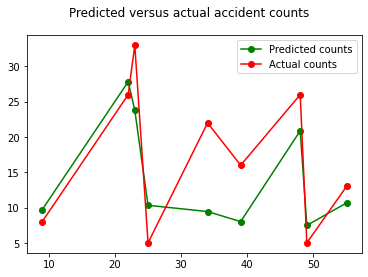

In [34]:
predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test['Y']
fig = plt.figure()
fig.suptitle('Predicted versus actual accident counts')
predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()

In [35]:
#STEP 5: Measuring the goodness-of-fit of the NB2 model

#Log-Likelihood: Likelihood-ratio (LR) test
LR = 2*(212.51-170.98)
print("LR test value =", LR)
print("χ2(1) = 6.635") # critical value of χ2(1) at the 1% significance level

LR test value = 83.06
χ2(1) = 6.635


In [39]:
#The Deviance and Pearson chi-squared statistics
NB_Deviance = 96.041
NB_Pearson_chi2 = 92.8

Chi_Squared_0_05 = 66.339
print("Deviance and Pearson chi-squared for the NB2 model are greater than the standard Chi-Squared value at p=0.05 and DF=49")
print("We might be able to do better!!")

Deviance and Pearson chi-squared for the NB2 model are greater than the standard Chi-Squared value at p=0.05 and DF=49
We might be able to do better!!
